# Segmentation application

# Imports

In [64]:
# What version of Python do you have?
import sys
import pandas as pd
import numpy as np
import math
from PIL import Image, ImageOps
import PIL
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from skimage import exposure

from tqdm import tqdm

import gc
import copy
import cv2

# import sklearn as sk
import tensorflow as tf
from tensorflow import keras
from pathlib import Path

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize, ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import get_file, plot_model, to_categorical

In [3]:
#IMPORT ALL LAYERS AND KERAS/TENSORFLOW PARAMS
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup, CategoryEncoding, GlobalMaxPooling2D, Rescaling, SeparableConv2D, BatchNormalization, Conv2D, MaxPool2D, Activation, Dropout, Dense, Flatten, Input, Concatenate, Add, AveragePooling2D, GlobalAveragePooling2D, AveragePooling1D, Reshape
from tensorflow.keras.models import Sequential, Model
from keras.activations import relu,leaky_relu
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2, l1, l1_l2
import keras_ocr 

In [4]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, confusion_matrix, f1_score, classification_report
from sklearn.metrics import mean_absolute_error

In [5]:
print(f"Python {sys.version}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Keras Version: {np.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Tensor Flow Version: 2.8.0
Keras Version: 2.8.0
Pandas 1.3.5
Keras Version: 1.22.3

GPU is available


In [6]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
!nvidia-smi

Thu May 19 17:45:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.77       Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   50C    P8    41W / 350W |   3161MiB / 12288MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
sys.path.append('../E-CNN-classifier-main/libs')
import ds_layer #Dempster-Shafer layer
import utility_layer_train #Utility layer for training
import utility_layer_test #Utility layer for training
import AU_imprecision #Metric average utility for set-valued classification

## Paths

In [9]:
pathTrainImgs = Path('../DB/train_images/')
cvsPath = Path('../DB/train.csv')

In [10]:
checkpointPath = Path('../Outputs/CNN/CHECKPOINTS/')
graphPath = Path('../Outputs/CNN/GRAPHS/')
pathSavedModel = Path('../Outputs/CNN/MODELS-PB/')
plotpath = Path('../Outputs/CNN/PLTS/')
evalspath = Path('../Outputs/CNN/EVALUATIONS/')

In [11]:
checkpointPath.mkdir(parents=True, exist_ok=True)
graphPath.mkdir(parents=True, exist_ok=True)
pathSavedModel.mkdir(parents=True, exist_ok=True)
plotpath.mkdir(parents=True, exist_ok=True)
evalspath.mkdir(parents=True, exist_ok=True)

## Random Seed

In [12]:
SEED = 42

## Global Variables

In [13]:
# IMAGE_SIZE = [1600,256] #original size
IMAGE_SIZE = [256,1600] #original size
# IMAGE_SIZE = [256,256]
IMAGE_RESIZE = [256,800]
CLASS_NAMES = [1,2,3,4]

## Utilities

In [14]:
def printAndSaveGraphs(pathWsave,nameOfModelGraph, history, Metrics, saveit = True, dpi = 300):

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model '+nameOfModelGraph+ ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation-HKonly'], loc='upper left')
    if saveit:
        plt.savefig(Path(pathWsave) / Path(nameOfModelGraph + '_loss.png'),dpi=dpi)
    plt.show()

    for met in Metrics:
        # summarize history for accuracy
        plt.plot(history.history[met.name])
        plt.plot(history.history['val_'+met.name])
        plt.title('model '+nameOfModelGraph+ met.name)
        plt.ylabel(met.name)
        # plt.plot(history.history[met])
        # plt.plot(history.history['val_'+met])
        # plt.title('model '+nameOfModelGraph+ met)
        # plt.ylabel(met)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        if saveit:
            plt.savefig(Path(pathWsave) / Path(nameOfModelGraph + met.name + '.png'),dpi=dpi)
            # plt.savefig(Path(pathWsave) / Path(nameOfModelGraph + met + '.png'),dpi=dpi)
        plt.show()

In [15]:
def loadPNGtoArray(paths,basePath, outSize = IMAGE_SIZE, resize = True):
    imgs = []
    for p in tqdm(paths):
        p = Path(p)
        # print(p)
        # fullPath = Path(str(basePath) + str(p))
        fullPath = basePath / p
        # print(basePath)
        # print(fullPath)
        if resize:
            img = load_img(fullPath,target_size=(outSize[0],outSize[1]))
        else:
            img = load_img(fullPath)
        imgs.append(img)
    imgs = np.array([np.array(fname) for fname in imgs])  #transform each element of list in numpy array    
    return imgs

# Inputs

In [16]:
# read in all our data
SevDB = pd.read_csv(cvsPath)

In [17]:
SevDB.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [18]:
mapping = {}
for x in range(len(CLASS_NAMES)):
    mapping[CLASS_NAMES[x]] = x



takename = copy.deepcopy(SevDB['ClassId'])
for x in range(len(takename)):
    takename[x] = mapping[takename[x]]


one_h_enc = to_categorical(takename)

i = 0
for n in CLASS_NAMES:
    SevDB[str('Error_Class_'+str(n))] = one_h_enc[:,i]
    i = i+1

In [19]:
X_full = pd.DataFrame(SevDB[['ImageId','EncodedPixels']])

Y_full = pd.DataFrame(SevDB[['Error_Class_1','Error_Class_2','Error_Class_3','Error_Class_4']])

In [20]:
class1 = Y_full.sum()[0]
print('ErrorClass1: ' + str(class1))
class2 = Y_full.sum()[1]
print('ErrorClass2: ' + str(class2))
class3 = Y_full.sum()[2]
print('ErrorClass3: ' + str(class3))
class4 = Y_full.sum()[3]
print('ErrorClass4: ' + str(class4))
total = Y_full.sum().sum()
print('total errors: ' + str(total))

ErrorClass1: 897.0
ErrorClass2: 247.0
ErrorClass3: 5150.0
ErrorClass4: 801.0
total errors: 7095.0


In [21]:
# X_train, X_val, Y_train, Y_val = train_test_split(X_full,Y_full, test_size=0.2,shuffle=True, random_state=SEED) #SEED
X_train, X_val, Y_train, Y_val = train_test_split(X_full,Y_full, test_size=0.2,shuffle=True)

## IMPORT IMGS

In [22]:
# X_train_IMGS = loadPNGtoArray(X_train['ImageId'],basePath=pathTrainImgs)
# X_val_IMGS = loadPNGtoArray(X_val['ImageId'],basePath=pathTrainImgs)

In [23]:
# imagePaths= Path('../DB/GC10-DET/images/images/')

# # 2048 x 1000

# trainset = tf.keras.utils.image_dataset_from_directory(imagePaths,batch_size=32,image_size=(512,512),label_mode='categorical',shuffle=True,seed=SEED,validation_split=0.2,subset='training')
# valset = tf.keras.utils.image_dataset_from_directory(imagePaths,batch_size=32,image_size=(512,512),label_mode='categorical',shuffle=True,seed=SEED,validation_split=0.2,subset='validation')

In [24]:
# print(X_train_IMGS.shape)
# print(X_val_IMGS.shape)

In [25]:
# plt.figure()
# plt.imshow(X_val_IMGS[0])

In [26]:
print(X_full['EncodedPixels'][505])

250798 1 251052 5 251306 8 251560 12 251814 15 252068 19 252322 22 252576 26 252831 28 253087 29 253343 31 253599 32 253855 34 254111 35 254359 1 254367 37 254615 3 254623 38 254872 4 254879 40 255128 5 255135 41 255385 47 255641 47 255898 45 256154 45 256410 45 256667 44 256923 43 257180 42 257436 42 257693 41 257949 40 258205 40 258462 39 258718 39 258975 38 259231 37 259488 36 259744 36 260001 35 260177 3 260257 34 260433 7 260513 34 260689 11 260770 33 260945 15 261026 33 261201 19 261283 31 261456 22 261539 31 261712 24 261796 30 261968 26 262052 30 262224 28 262313 24 262480 30 262579 14 262736 32 262844 5 262992 34 263248 36 263503 38 263759 38 264015 38 264271 37 264527 37 264783 37 265039 37 265295 36 265550 37 265806 37 266062 37 266318 36 266574 36 266830 36 267086 36 267342 35 267597 36 267853 36 268109 36 268365 35 268621 35 268877 35 269133 35 269389 34 269644 35 269900 35 270156 35 270412 34 270668 34 270941 17 395510 2 395763 6 395996 3 396016 9 396252 7 396270 12 39650

## Apply segmentation on images

In [72]:
def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)

def createMask(imNames, maskPXs, pathOut):
    masks = []
    for pxs, pt in tqdm(zip(maskPXs,imNames)):
        pxs = pxs.split(' ')
        # print(pxs)
        mask = [0] * IMAGE_SIZE[0] * IMAGE_SIZE[1]
        # print(len(mask))
        for px,npx in pairwise(pxs):
            px = int(px)
            npx = int(npx)
            # print(int(px))
            # print(int(npx))
            for i in range(npx):
                mask[px-1+i] = 1
        
        imout = Image.new(mode='1',size=[IMAGE_SIZE[0],IMAGE_SIZE[1]])
        imout.putdata(mask)
        
        imout = imout.rotate(90, expand=1)
        imout = imout.transpose(PIL.Image.FLIP_TOP_BOTTOM)
        imout.save(pathOut + pt)
        masks.append(imout)
        # break

    return masks

In [73]:
masks = createMask(X_full['ImageId'],X_full['EncodedPixels'],'../DB/train_images_masks/')

7095it [00:38, 185.10it/s]


In [74]:
print(masks[0])

<PIL.Image.Image image mode=1 size=1600x256 at 0x28DAC9297F0>


In [75]:
print(X_full['ImageId'][0])

0002cc93b.jpg


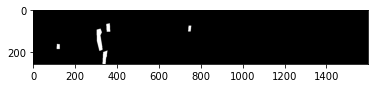

In [76]:
plt.figure()
plt.imshow(masks[0])